In [1]:
import os
import sys

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_DIR)
print(PROJECT_DIR)

c:\Users\liose\Desktop\aidl-2025-project


In [2]:
# Load dataset
from src.data.load_workout_data import load_workout_data
image_dir = os.path.join(PROJECT_DIR, 'workout_dataset/images')
annotation_dir = os.path.join(PROJECT_DIR, 'workout_dataset/labels')

keypoints_array, images_array, bounding_boxes_array, classes_array = load_workout_data(image_dir=image_dir, annotation_dir=annotation_dir)
print(len(keypoints_array), len(images_array), len(bounding_boxes_array), len(classes_array))

13812 13812 13812 13812


In [3]:
print(keypoints_array[0])
print(images_array[0])
print(bounding_boxes_array[0])
print(classes_array[0])

[[0.524567, 0.117087], [0.558409, 0.102889], [0.530581, 0.091301], [0.620674, 0.172557], [0.0, 0.0], [0.669786, 0.436631], [0.501232, 0.36792], [0.657868, 0.771478], [0.482892, 0.609277], [0.610987, 0.989577], [0.459563, 0.796943], [0.603892, 0.933817], [0.488061, 0.900847], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
c:\Users\liose\Desktop\aidl-2025-project\workout_dataset/images\barbell biceps curl\barbell biceps curl_1000001.jpg
[0.40833300000000006, 0.0, 0.733333, 1.0]
barbell biceps curl


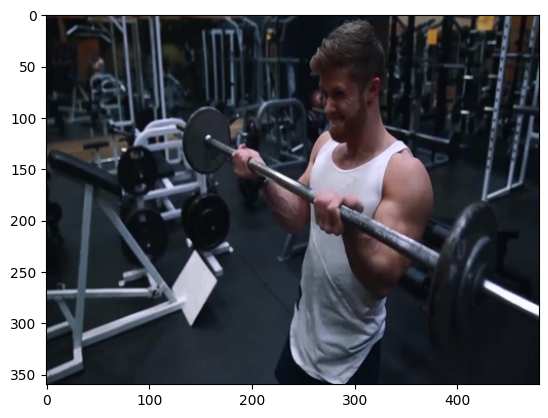

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = np.array(Image.open(images_array[7]))
plt.imshow(image)

In [5]:
from src.data.dataloader import create_dataloaders
# Create dataloaders
train_loader, val_loader, class_name_to_idx = create_dataloaders(images_array, bounding_boxes_array, keypoints_array, classes_array, batch_size=64, resize_to=[480, 360])

# Reverse the class_name_to_idx mapping
idx_to_class_name = {idx: class_name for class_name, idx in class_name_to_idx.items()}

# Check dataloaders
#print(len(train_loader), len(val_loader))
#print(train_loader.dataset[0])

Class (workout_label): lat pulldown


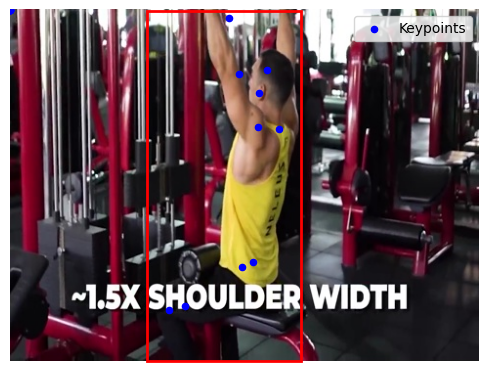

In [6]:
import torch
import matplotlib.pyplot as plt

image = train_loader.dataset[0][0].permute(1, 2, 0)
image = image.numpy()
plt.imshow(image)
plt.axis('off')


bbox = train_loader.dataset[0][1]['bbox'].numpy()
workout_label_name = train_loader.dataset[0][1]['workout_label_name']
keypoints = train_loader.dataset[0][1]['keypoints'].numpy()

h, w = image.shape[:2]
bbox = (bbox * np.array([w, h, w, h])).astype(int).flatten()

plt.gca().add_patch(plt.Rectangle(
    (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
    linewidth=2, edgecolor='red', facecolor='none'
))

keypoints[:, 0] *= w 
keypoints[:, 1] *= h 
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='blue', label='Keypoints')

print(f"Class (workout_label): {workout_label_name}")

plt.legend()
plt.show()

In [7]:
import torch.nn as nn
import torchvision

class Model(nn.Module):
    def __init__(self, num_classes, num_keypoints, use_resnet34=False):
        super(Model, self).__init__()

        self.num_classes = num_classes
        self.num_keypoints = num_keypoints

        if use_resnet34:
            self.backbone = torchvision.models.resnet34(pretrained=True)
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
            self.input_size = 512
        else:
            self.backbone = torchvision.models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
            self.input_size = 2048

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.bbox_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )

        self.keypoints_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, num_keypoints * 3)
        )

        self.workout_label_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        # Global Average Pooling (GAP) layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        bbox = self.bbox_head(x).unsqueeze(1)

        keypoints = self.keypoints_head(x).view(-1, self.num_keypoints, 3)
        keypoints = torch.sigmoid(keypoints)  
        # Apply thresholding to visibility (visibility = 1 if > 0.5, else 0)     
        keypoints_visibility = keypoints[:, :, 2]  # The visibility values are in the 3rd channel
        keypoints_visibility = (keypoints_visibility > 0.5).float()  # Set visibility to 1 or 0
        updated_keypoints = keypoints.clone()  # Clone the keypoints tensor
        updated_keypoints[:, :, 2] = keypoints_visibility

        workout_label = self.workout_label_head(x)

        return bbox, updated_keypoints, workout_label
    
    def compute_losses(self, outputs, targets):

        bbox_targets = torch.stack([target['bbox'] for target in targets]) 
        keypoints_targets = torch.stack([target['keypoints'] for target in targets]) 
        workout_label_targets = torch.stack([target['workout_label'] for target in targets]) 

        bbox_loss = nn.L1Loss()(outputs[0], bbox_targets)

        keypoints_loss = nn.L1Loss()(outputs[1], keypoints_targets)

        workout_label_indices = workout_label_targets.argmax(dim=1)
        workout_label_loss = nn.CrossEntropyLoss()(outputs[2], workout_label_indices)

        return bbox_loss, keypoints_loss, workout_label_loss
    

In [8]:
import torch.optim as optim

num_classes = len(set(classes_array)) 
num_keypoints = 17
model = Model(num_classes=num_classes, num_keypoints=num_keypoints)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

c:\Users\liose\Desktop\aidl-2025-project\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\liose\Desktop\aidl-2025-project\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [ ]:
from tqdm import tqdm
from src.utils.metrics import calculate_classification_accuracy, calculate_keypoint_accuracy, calculate_bbox_accuracy

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize accumulators for accuracy metrics at the epoch level
    total_classification_correct = 0
    total_classification_count = 0
    total_bbox_correct = 0
    total_bbox_count = 0
    total_keypoints_correct = 0
    total_keypoints_count = 0

    for batch_idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):

        images = images.to(device)
        new_targets = []
        
        for i in range(len(targets["bbox"])):  
            
            new_targets.append({
                "bbox": targets["bbox"][i].to(device),  
                "workout_label": targets["workout_label"][i].to(device),  
                "keypoints": targets["keypoints"][i].to(device), 
            })
        
        optimizer.zero_grad() 

        # Forward pass
        output = model(images) 
        losses = model.compute_losses(output, new_targets)
        loss = sum(loss for loss in losses)

        loss.backward() 
        optimizer.step()  

        running_loss += loss.item()

        bbox, keypoints, workout_label = output


        # Calculate and accumulate accuracy metrics
        workout_label_targets = torch.stack([target['workout_label'] for target in new_targets]) 
        classification_accuracy = calculate_classification_accuracy(workout_label, workout_label_targets)
        total_classification_correct += classification_accuracy * len(workout_label_targets)
        total_classification_count += len(workout_label_targets)

        # Calculate bbox and keypoint accuracy
        bbox_targets = torch.stack([target['bbox'] for target in new_targets]) 
        bbox_accuracy = calculate_bbox_accuracy(bbox, bbox_targets)
        total_bbox_correct += bbox_accuracy * len(bbox_targets)
        total_bbox_count += len(bbox_targets)

        # Calculate keypoint accuracy
        keypoints_targets = torch.stack([target['keypoints'] for target in new_targets]) 
        keypoints_accuracy = calculate_keypoint_accuracy(keypoints, keypoints_targets)
        total_keypoints_correct += keypoints_accuracy * len(keypoints_targets)
        total_keypoints_count += len(keypoints_targets) 

        if batch_idx == 0:
            # Reverse the class_name_to_idx mapping
            predicted_indices = torch.argmax(workout_label, dim=1) 
            predicted_class_names = [idx_to_class_name[idx.item()] for idx in predicted_indices]
            true_indices = torch.argmax(workout_label_targets, dim=1) 
            true_class_names = [idx_to_class_name[idx.item()] for idx in true_indices]
            print(f"Predicted Class Names: {predicted_class_names}")
            print(f"True Class Names: ", true_class_names)



    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Calculate and print epoch-level accuracy
    epoch_classification_accuracy = total_classification_correct / total_classification_count
    epoch_bbox_accuracy = total_bbox_correct / total_bbox_count
    epoch_keypoints_accuracy = total_keypoints_correct / total_keypoints_count
    print(f"Epoch {epoch+1} Classification Accuracy: {epoch_classification_accuracy}")
    print(f"Epoch {epoch+1} BBox Accuracy: {epoch_bbox_accuracy}")
    print(f"Epoch {epoch+1} Keypoints Accuracy: {epoch_keypoints_accuracy}")
    

  0%|          | 0/173 [00:00<?, ?it/s]

  1%|          | 1/173 [00:01<03:27,  1.21s/it]

Predicted Class Names: ['lateral raises', 'lateral raises', 'lateral raises', 'lateral raises', 'push up', 'leg raises', 'leg raises', 'lateral raises', 'chest fly machine', 'chest fly machine', 'leg raises', 'push up', 'chest fly machine', 'lateral raises', 'lateral raises', 'leg raises', 'lateral raises', 'chest fly machine', 'lateral raises', 'push up', 'push up', 'lateral raises', 'lateral raises', 'leg raises', 'lateral raises', 'leg raises', 'leg raises', 'lateral raises', 'lateral raises', 'leg raises', 'lateral raises', 'leg raises', 'push up', 'russian twist', 'lateral raises', 'lateral raises', 'russian twist', 'lateral raises', 'leg raises', 'lateral raises', 'chest fly machine', 'leg raises', 'leg raises', 'chest fly machine', 'lateral raises', 'leg raises', 'leg raises', 'leg raises', 'lateral raises', 'leg raises', 'lateral raises', 'lateral raises', 'leg raises', 'leg raises', 'hip thrust', 'lateral raises', 'chest fly machine', 'lateral raises', 'lateral raises', 'leg r

  5%|▌         | 9/173 [00:07<02:14,  1.22it/s]